In [1]:
import os
import sys 
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
IMG_DIR="Galaxy_data/images_training_rev1" 
MEAN_IMG="mean.jpg"

zoom_factor = 2

mean_img_array = cv2.imread(MEAN_IMG, cv2.IMREAD_GRAYSCALE)
mean_img_pil = Image.fromarray(mean_img_array)
mean_img_128x128 = np.array(mean_img_pil.resize((256, 256), Image.Resampling.NEAREST))
zoomed_mean_img_128x128 = cv2.resize(mean_img_128x128, None, fx=zoom_factor, fy=zoom_factor)
crop_x, crop_y, crop_width, crop_height = 128, 128, 256, 256  # Adjust as needed
mean_cropped_image = zoomed_mean_img_128x128[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]

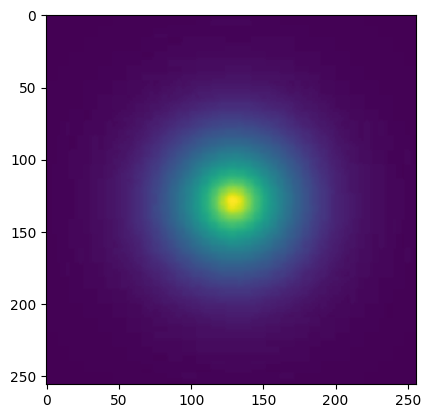

In [3]:
plt.imshow(mean_cropped_image)

In [ ]:
IMG_DIR="Galaxy_data/images_training_rev1" 
MEAN_IMG="mean.jpg"

# the zooming factor
zoom_factor = 2

print("Processing...")
original_galaxy_imgs = {}
cropped_galaxy_imgs = {}
cropped_galaxy_imgs_flat = {}
count = 1
total = len(os.listdir(IMG_DIR)) #200

for img in os.listdir(IMG_DIR):
    if count == total + 1:
        break
    sys.stdout.write("\r" + str(count) + " / " + str(total))
    sys.stdout.flush()

    # preprocessing images: reading, zooming, cropping
    img_array = cv2.imread(os.path.join(IMG_DIR, img), cv2.IMREAD_GRAYSCALE)
    img_pil = Image.fromarray(img_array)
    img_256x256 = np.array(img_pil.resize((256, 256), Image.Resampling.NEAREST))
    zoomed_img_256x256 = cv2.resize(img_256x256, None, fx=zoom_factor, fy=zoom_factor)
    crop_x, crop_y, crop_width, crop_height = 128, 128, 256, 256  
    cropped_img = zoomed_img_256x256[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]

    # storing the images in dic dataframe: id of galaxy and its array
    idx = int(os.path.splitext(img)[0])
    original_galaxy_imgs[idx] = img_256x256
    cropped_galaxy_imgs[idx] = np.array(cropped_img)
    cropped_galaxy_imgs_flat[idx] = np.array(cropped_img).flatten()
    count += 1

# saving the proccessed data
saving_path = "proccessed_data/"
np.save(saving_path + "original_galaxy_imgs.npy", original_galaxy_imgs)
np.save(saving_path + "cropped_galaxy_imgs.npy", cropped_galaxy_imgs)
np.save(saving_path + "cropped_galaxy_imgs_flat.npy", cropped_galaxy_imgs_flat)

print()
print("Done!")

In [ ]:
plt.imshow(original_galaxy_imgs[list(original_galaxy_imgs.keys())[5]])

In [ ]:
plt.imshow(cropped_galaxy_imgs[list(cropped_galaxy_imgs.keys())[5]])

In [8]:
saving_path = "proccessed_data/"
load_crop = np.load(saving_path + "cropped_galaxy_imgs.npy", allow_pickle=True).item()

In [9]:
def test_sample(data_array, n_samples):
    test_dict = {}
    count = 0

    for key, val in data_array.items():
        if(count < n_samples):
            test_dict[key] = val
            count += 1
    return test_dict

In [18]:
test_dict = test_sample(load_crop, 4)

In [19]:
# transform
def our_PCA(data_dict, k):
    print("Performing PCA ...")
    pca_galaxy_imgs = {}
    inv_pca_galaxy_imgs = {}
    pca = PCA(n_components=k, svd_solver='full', random_state=42)
    count = 1
    total = len(data_dict)
    for key, val in data_dict.items():
        if count == total + 1:
            break
        sys.stdout.write("\r" + str(count) + " / " + str(total))
        sys.stdout.flush()
        pca_galaxy_imgs[key] = pca.fit_transform(val)
        inv_pca_galaxy_imgs[key] = pca.inverse_transform(pca_galaxy_imgs[key])
        count += 1
    print("\ndone!")
    return  pca_galaxy_imgs, inv_pca_galaxy_imgs

In [25]:
# pca_galaxy_imgs, inv_pca_galaxy_imgs = our_PCA(test_dict, 0.9)
pca_galaxy_imgs, inv_pca_galaxy_imgs = our_PCA(test_dict, 0.95)

np.save(saving_path + "pca_galaxy_imgs.npy", pca_galaxy_imgs)
np.save(saving_path + "inv_pca_galaxy_imgs.npy", inv_pca_galaxy_imgs)

Performing PCA ...
4 / 4
done!


In [26]:
# print(test_dict[873932].shape)
print(load_crop[873932].shape)
print(pca_galaxy_imgs[873932].shape)

(256, 256)


KeyError: 873932

In [27]:
len(inv_pca_galaxy_imgs)

4

In [28]:
# function to plot different imgs stored in the dict
def plot_list(data_dict, n_imgs):
    fig, ax = plt.subplots(figsize = (20, 20))
    count = 0
    for i in range(0, len(data_dict)):
        if(count < n_imgs):
            count += 1
            plt.subplot(5, 5, i + 1)
            plt.title('Galaxy data {}'.format(i-1))
            img = list(data_dict.values())[i]
            plt.imshow(img)

/scratch_local/ipykernel_2723431/588829251.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i + 1)


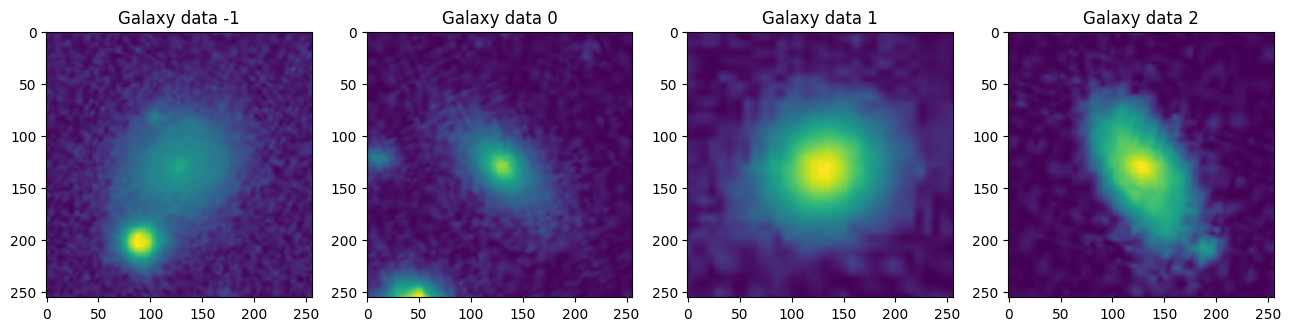

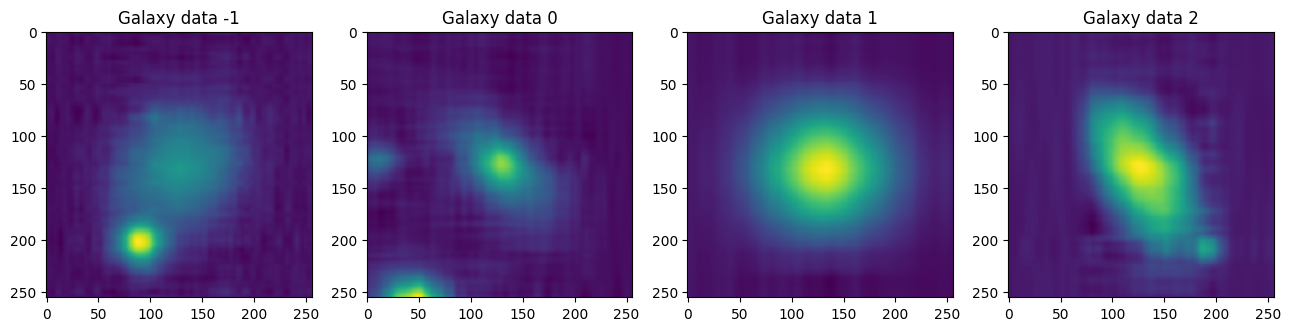

In [29]:
# this is to plot 25 samples of the cropped imgs

n_imgs = 4

plot_list(load_crop, n_imgs)
plot_list(inv_pca_galaxy_imgs, n_imgs)

In [26]:
# this is to plot 25 samples of the reconstructed imgs after performing pca
